C:\Users\ChenJ\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 0/10 Loss: 0.0381200835108757
Epoch 1/10 Loss: 0.039165329188108444
Epoch 2/10 Loss: 0.026100849732756615
Epoch 3/10 Loss: 0.02706434763967991
Epoch 4/10 Loss: 0.028387771919369698
Epoch 5/10 Loss: 0.009516303427517414
Epoch 6/10 Loss: 0.006030305754393339
Epoch 7/10 Loss: 0.013614301569759846
Epoch 8/10 Loss: 0.008819004520773888
Epoch 9/10 Loss: 0.00518388394266367
MAE: 1.2459217309951782, RMSE: 1.3099708557128906, R^2: -9.780519583248804


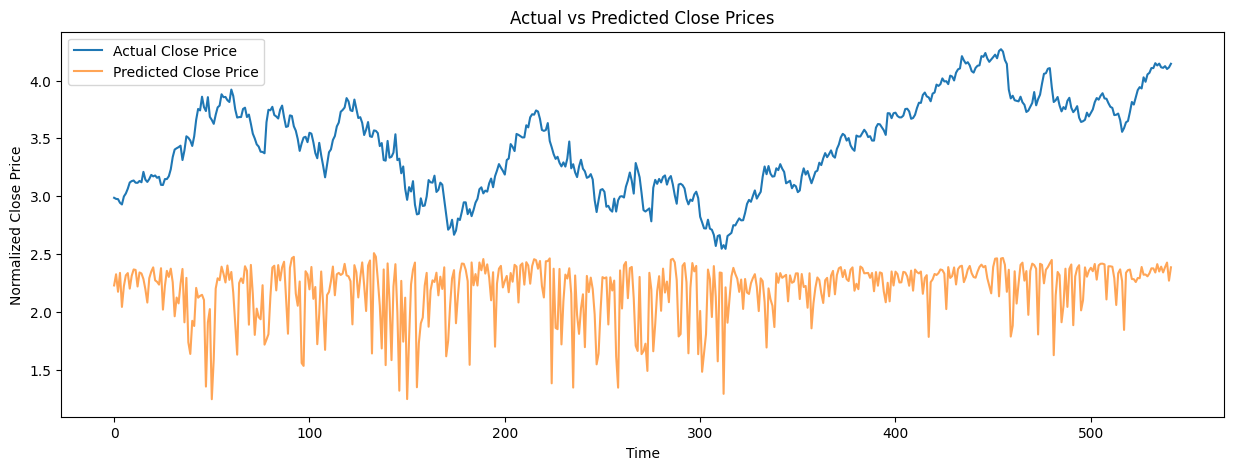

In [14]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Read the CSV file into a DataFrame
df = pd.read_csv("data/AAPL.csv")

# Select the features for training
features = df[["open", "high", "low", "close", "change", "pct_chg", "vol", "amount"]]

# Normalize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Prepare the data with a lookback of 10 days
def create_inout_sequences(input_data, lookback):
    inout_seq = []
    L = len(input_data)
    for i in range(L-lookback):
        train_seq = input_data[i:i+lookback, :]
        train_label = input_data[i+lookback, 3]  # Assuming index 3 is 'close' price
        inout_seq.append((train_seq, train_label))
    return inout_seq

seq_length = 3
inout_seq = create_inout_sequences(scaled_features, seq_length)

# Split the data into train and test sets
train_size = int(len(inout_seq) * 0.95)
train_seq = inout_seq[:train_size]
test_seq = inout_seq[train_size:]

# Convert sequences to PyTorch DataLoader
def create_dataloader(sequences, sh, batch_size=64):
    feature_sequences, label_sequences = zip(*sequences)
    feature_sequences = torch.FloatTensor(feature_sequences)
    label_sequences = torch.FloatTensor(label_sequences)
    dataset = TensorDataset(feature_sequences, label_sequences.unsqueeze(1))  # Ensure labels are of shape (batch_size, 1)
    return DataLoader(dataset, shuffle=sh, batch_size=batch_size)

# Convert sequences to PyTorch DataLoader
batch_size = 64
train_loader = create_dataloader(train_seq, True, batch_size)
test_loader = create_dataloader(test_seq, False, batch_size)

# Define the Transformer Model
class TransformerModel(nn.Module):
    def __init__(self, feature_size, num_layers, nhead, hidden_dim, dropout=0.5):
        super(TransformerModel, self).__init__()
        self.src_mask = None
        self.pos_encoder = nn.Linear(feature_size, hidden_dim)
        self.encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.decoder = nn.Linear(hidden_dim, 1)
        self.init_weights()

    def init_weights(self):
        initrange = 0.1
        self.pos_encoder.bias.data.zero_()
        self.pos_encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src):
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output)
        return output[:, -1, :]  # Take the output of the last time step

# Initialize the model
feature_size = 8  # Number of input features
num_layers = 3
nhead = 2
hidden_dim = 512
dropout = 0.1

model = TransformerModel(feature_size, num_layers, nhead, hidden_dim, dropout).to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch}/{num_epochs} Loss: {loss.item()}")

num_epochs = 10
train_model(model, train_loader, criterion, optimizer, num_epochs)

# Evaluation function with MAE, RMSE, and R^2
def evaluate_model(model, test_loader):
    model.eval()
    predictions, actuals = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            output = model(inputs)
            predictions.append(output.cpu().numpy())
            actuals.append(labels.cpu().numpy())
    
    predictions, actuals = np.concatenate(predictions), np.concatenate(actuals)
    mae = mean_absolute_error(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    r2 = r2_score(actuals, predictions)
    print(f"MAE: {mae}, RMSE: {rmse}, R^2: {r2}")
    return predictions, actuals

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)

# Visualization of the predicted vs actual close prices
plt.figure(figsize=(15, 5))
plt.plot(actuals, label='Actual Close Price')
plt.plot(predictions, label='Predicted Close Price', alpha=0.7)
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()